# Dragut 2019 – empirical curve (retail phone regex)

Baseline: simple phone-number regex, labels revealed in 5-minute blocks.

In [1]:
# --- Imports and data load ---
import pandas as pd, pathlib, os, sys, re, json
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

ROOT = pathlib.Path(os.getcwd()).parent          # project root
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))

RAW = ROOT / "data" / "raw" / "dragut_phone.csv"   # <— your file
df = pd.read_csv(RAW)

print("Rows:", len(df))
df.head()

Rows: 19078


,Outlet,String,Label,TagLabel,R.E.1,R.E.2,R.E.3,R.E.4,R.E.5,R.E.6,R.E.7,R.E.8,R.E.tag,R.E.tag.old
0,74150,r SALE Date: 31 Mar 1993 11:38:38,0,oooooooooooooooooooooooooooooooooo,0,0,0,0,0,1,0,0,oooooooooooooooooooooooooooooooooo,ooooooooooooooooooooyyyyoooooooooo
1,74150,Mar 1993 11:38:38 -0500 Organizat,0,oooooooooooooooooooooooooooooooooo,0,0,0,0,0,1,0,0,oooooooooooooooooooooyyyyyyyyyyyoo,oooooyyyyoooooooooooyyyyoooooooooo
2,74150,.edu BOAT For SALE 1989 23' IMPER,0,oooooooooooooooooooooooooooooooooo,0,0,0,0,0,1,0,0,oooooooooooooooooooooooooooooooooo,ooooooooooooooooooooyyyyoooooooooo
3,74150,ontact Gerald at 1-(419)-756-2950,1,nnnnnnnnnnnnnnnnnyyyyyyyyyyyyyyyy,0,0,0,0,1,0,0,0,oooooooooooooooooyyyyyyyyyyyyyyyy,oooooooooooooooooyyyyyyyyyyyyyyyy
4,74150,t Gerald at 1-(419)-756-2950,1,nnnnnnnnnnnnyyyyyyyyyyyyyyyynnnnn,0,0,0,0,1,0,0,0,ooooooooooooyyyyyyyyyyyyyyyyooooo,ooooooooooooyyyyyyyyyyyyyyyyooooo


In [2]:
phone_pat = re.compile(r"\(?\d{3}\)?[-\s]\d{3}[-]\d{4}")

def predict_phone(series: pd.Series) -> np.ndarray:
    """Return 1 if regex fires in the string, else 0."""
    return series.str.contains(phone_pat).astype(int).values

In [3]:
# --- F1 vs annotation minutes (5-min blocks) ---
f1_points = []

y_true = df["Label"].values                # 1 = phone, 0 = not
y_pred  = predict_phone(df["String"])

minutes_per_row = 2      # ← assume annotator labels ~30 rows / hour
block = 5                # granularity in plot (minutes)

for m in range(0, 160, block):
    rows = int(m / minutes_per_row)
    if rows == 0:
        f1 = 0.0
    else:
        f1 = precision_recall_fscore_support(
            y_true[:rows], y_pred[:rows],
            average="binary", zero_division=0)[2]
    f1_points.append((m, f1))

m_values, f1_values = zip(*f1_points)


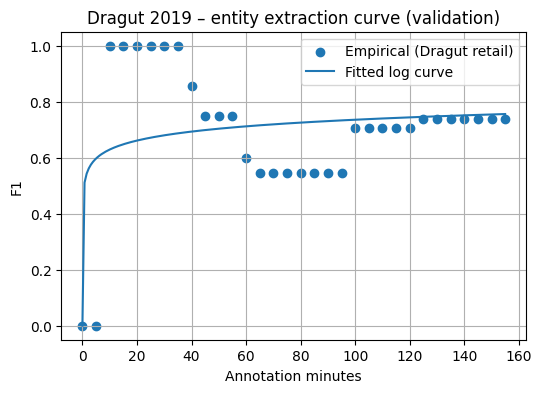

Fitted  a=0.046, b=80419.0618,  RMSE=0.2404


In [4]:
import matplotlib.pyplot as plt
from src.curves import fit_log_curve, log_model      # you wrote these

a, b, rmse = fit_log_curve(m_values, f1_values)

plt.figure(figsize=(6,4))
plt.scatter(m_values, f1_values, label="Empirical (Dragut retail)")
m_plot = np.linspace(0, max(m_values), 200)
plt.plot(m_plot, log_model(m_plot, a, b), label="Fitted log curve")
plt.title("Dragut 2019 – entity extraction curve (validation)")
plt.xlabel("Annotation minutes");   plt.ylabel("F1")
plt.legend();   plt.grid(True)
FIG = ROOT / "docs" / "figures" / "dragut_log_fit.png"
plt.savefig(FIG, dpi=120)
plt.show()

print(f"Fitted  a={a:.3f}, b={b:.4f},  RMSE={rmse:.4f}")

In [5]:
# --- Persist parameters ---
CURVES = ROOT / "data" / "curves.json"
curves = json.loads(CURVES.read_text())           # existing Kang etc.
curves["Dragut2019"] = {"a": a, "b": b}
CURVES.write_text(json.dumps(curves, indent=2))
print("Saved →", CURVES)

Saved → c:\Users\zuzia\OneDrive - Temple University\Documents\MS Computational DS\Summer 2025\Research\Project\cost-utility-calculator\data\curves.json
